This document contains the latest results of my simulator. First, import the simulator and required packages:

In [4]:
import numpy as np
from pfb_fixed import FixPFB, iterffft_natural_DIT,make_fix_twiddle, bitrevfixarray
from pfb_floating import FloatPFB, iterfft_natural_in_DIT, make_twiddle, bitrevarray
import scipy.io as spio
from fixpoint import cfixpoint,fixpoint
from fftfirpfbplot import fftresplotter, firresplotter, pfbresplotter
from fftfirpfbplot import fftrresplotter, fftiresplotter

## System under test:
The configuration I'm looking to test is a 4k, 8-tap, hann filtered F-Engine. It will process 18-bit input data and produce 18-bit output data. 

## Testing procedure:
I've loaded a tone and noisy tone into the CASPER PFB that runs in MeerKAT and recorded both the input and output vectors. While I've tried to ensure that the input vector corresponds to the output vectors exactly, this is very difficult to guarantee... and I've not found a way just yet, but if necessary I'll work on it.

This document is broken into 3 sections where I first test the FFT alone, then the FIR filterbank and then the full PFB. To begin, we start by comparing the FFT's.

### The FFT:

In [5]:
fftinputdata = spio.loadmat('fftinputdata.mat', squeeze_me=True)['inputdata']
fftrealoutputdata = spio.loadmat('fftrealdataout.mat', squeeze_me=True)['realoutputdata']
fftimagoutputdata = spio.loadmat('fftimagdataout.mat', squeeze_me=True)['imagoutputdata']

I've started by loading the pure tone input vector and FFT output vector. These are loaded into Python vectors and will now be processed by the Python simulator:

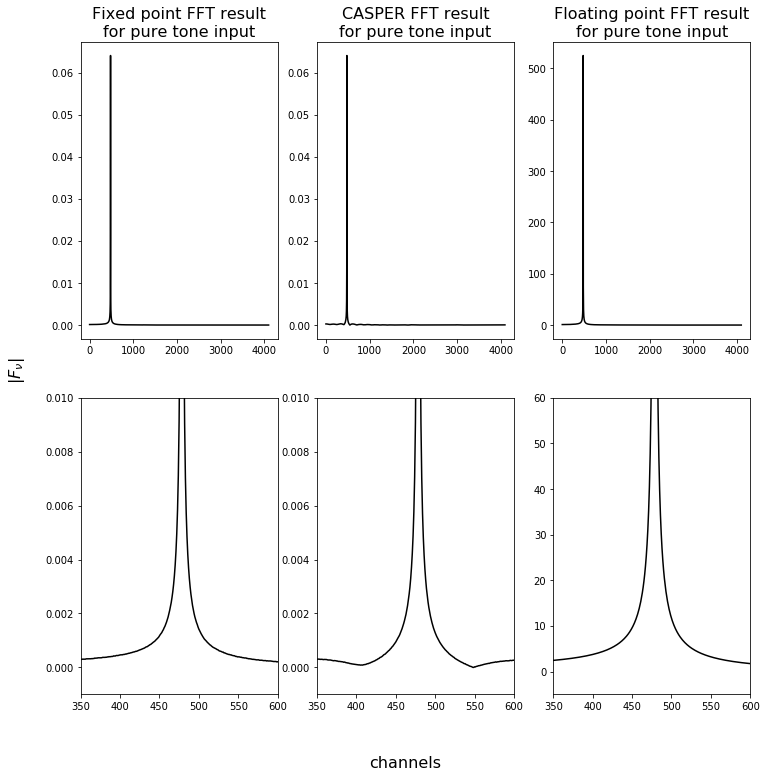

In [6]:
#DECLARE TWIDDLE FACTOR ARRAYS FOR THE FLOATING AND FIXED POINT FFT
b = make_twiddle(2**13)
b = bitrevarray(b,2**12)
a=make_fix_twiddle(2**13,17,16)
a = bitrevfixarray(a,2**12)

#CALCULATE FFT's 
data = cfixpoint(17,17)
data.from_complex(fftinputdata)
fltfftres = np.abs(iterfft_natural_in_DIT(fftinputdata,b))[:4096]
casfftres = np.abs(fftrealoutputdata+1j*fftimagoutputdata)
fxdfft = iterffft_natural_DIT(data,a,[1,1,1,1,1,1,1,1,1,1,1,1,1],17,17,17)
fxdfftres = np.abs(fxdfft.to_complex()[:4096])

#PLOT
%matplotlib inline
fftresplotter(fxdfftres,casfftres,fltfftres,'for pure tone input')

The magnitudes match up and we have a spike in the same channel for all outputs. There is an odd wobble in the CASPER FFT floor... I'm not sure what that is. Note that as expected, the floating point has a magnitude $2^{13}$ times the CASPER and fixedpoint simulator magnitudes (owing to the aggressive shifting of 8191 used). 

Next we inspect the FFT results for a tone with noise.

In [7]:
fftinputdatans = spio.loadmat('fftinputdata_ns.mat', squeeze_me=True)['inputdata']
fftrealoutputdatans = spio.loadmat('fftrealdataout_ns.mat', squeeze_me=True)['realoutputdata']
fftimagoutputdatans = spio.loadmat('fftimagdataout_ns.mat', squeeze_me=True)['imagoutputdata']

Having loaded the noisy tone MATLAB vectors into Python vectors I'll again compare the FFT outputs below:

Input SNR:  51.623561812903134 
Fixed FFT SNR:  46.43531561132646 
CASPER FFT SNR:  46.67241400859076 
Floating FFT SNR:  46.43244743347168


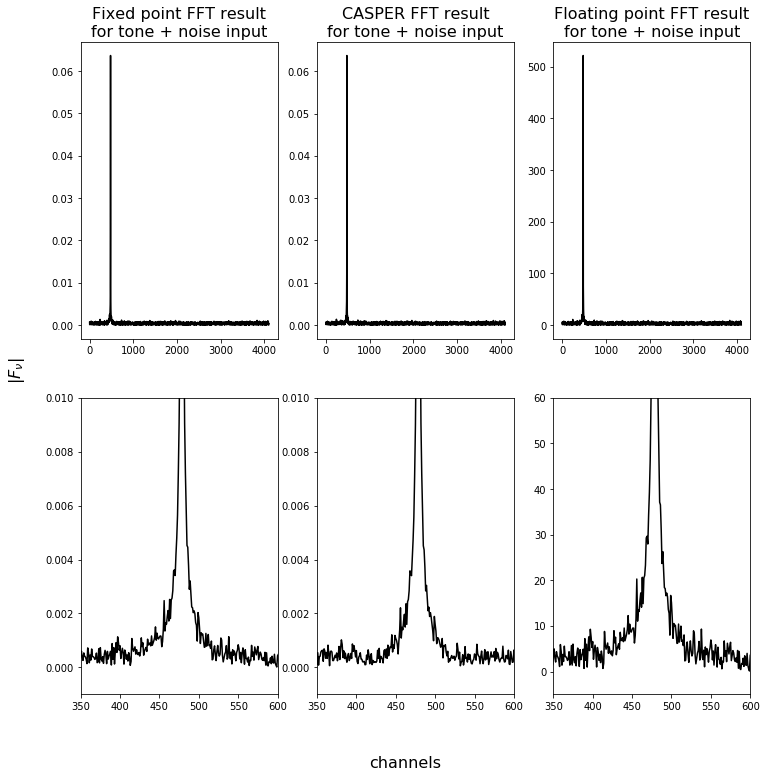

In [8]:
#DECLARE TWIDDLE FACTOR ARRAYS FOR THE FLOATING AND FIXED POINT FFT
b = make_twiddle(2**13)
b = bitrevarray(b,2**12)
a=make_fix_twiddle(2**13,17,16)
a = bitrevfixarray(a,2**12)

#CALCULATE FFT's 
data = cfixpoint(17,17)
data.from_complex(fftinputdatans)
fltfftresns = np.abs(iterfft_natural_in_DIT(fftinputdatans,b))[:4096]
casfftresns = np.abs(fftrealoutputdatans+1j*fftimagoutputdatans)
fxdfftresns = np.abs(iterffft_natural_DIT(data,a,[1,1,1,1,1,1,1,1,1,1,1,1,1],17,17,17).to_complex())[:4096]

#PLOT
%matplotlib inline
fftresplotter(fxdfftresns,casfftresns,fltfftresns,'for tone + noise input')

#CALCULATE SNR's
fftinputsnr = 20*np.log10(np.max(fftinputdata)/np.mean(fftinputdatans-fftinputdata))
fxdfftsnr = 20*np.log10(np.max(fxdfftres)/np.mean(fxdfftresns-fxdfftres))
casfftsnr = 20*np.log10(np.max(casfftres)/np.mean(casfftresns-casfftres))
fltfftsnr = 20*np.log10(np.max(fltfftres)/np.mean(fltfftresns-fltfftres))

print("Input SNR: ",fftinputsnr, "\nFixed FFT SNR: ",fxdfftsnr,"\nCASPER FFT SNR: ",casfftsnr,"\nFloating FFT SNR: ",
     fltfftsnr)

Thats a near perfect bit-wise match (although that may not be fair to say considering that I'm unsure whether the input data corresponds to the output data). The wobble in the CASPER FFT floor still exists and will be examined (perhaps I've read data out the CASPER FFT too soon). Overall however this is a very pleasing result. 

Having a look at the SNR results for these FFT results shows the near-accuracy between the simulator and the CASPER FFT.

### The FIR:
Next, we I'll compare the FIR register results, starting with the pure tone result.

In [9]:
firinputdata = spio.loadmat('firinputdata.mat', squeeze_me=True)['inputdata']
firoutputdata = spio.loadmat('firoutputdata.mat', squeeze_me=True)['outputdata']

Having loaded the pure tone MATLAB vectors into Python, I'll now compare the FIR outputs below:

In [10]:
#CREATE FIXED AND FLOATING PFB's AND RUN ON INPUT DATA
#HAVE TO REPLICATE CODE FOUND IN THE PFB SIMULATORS TO GET THE LAST FIR OUTPUT (WHEN ALL FIRS WERE FULL)
pfbflt = FloatPFB(2**13,8)
pfbflt.run(firinputdata)
datfirfxd = cfixpoint(17,17)
datfirfxd.from_complex(firinputdata)
pfbfxd = FixPFB(2**13,8,17,17,17,17,8191,17,chan_acc=False,w='hann')
pfbfxd.run(datfirfxd)
firoutflt =np.sum(pfbflt.reg*pfbflt.window,axis=1)/ (2**pfbflt.firsc)
X_real = pfbfxd.reg_real*pfbfxd.window
X_imag = pfbfxd.reg_imag*pfbfxd.window
prodgrth = X_real.bits - pfbfxd.bits_fft-1
X = cfixpoint(real = X_real.sum(axis=1),imag = X_imag.sum(axis =1))                                 
X >> prodgrth + pfbfxd.firsc
X.bits = pfbfxd.bits_fft
X.fraction = pfbfxd.bits_fft
X.normalise()

#OUR OUTPUTS
fxdfirres = np.abs(X.to_complex())
casfirres = np.abs(firoutputdata)
fltfirres = np.abs(firoutflt)

Now plotting:


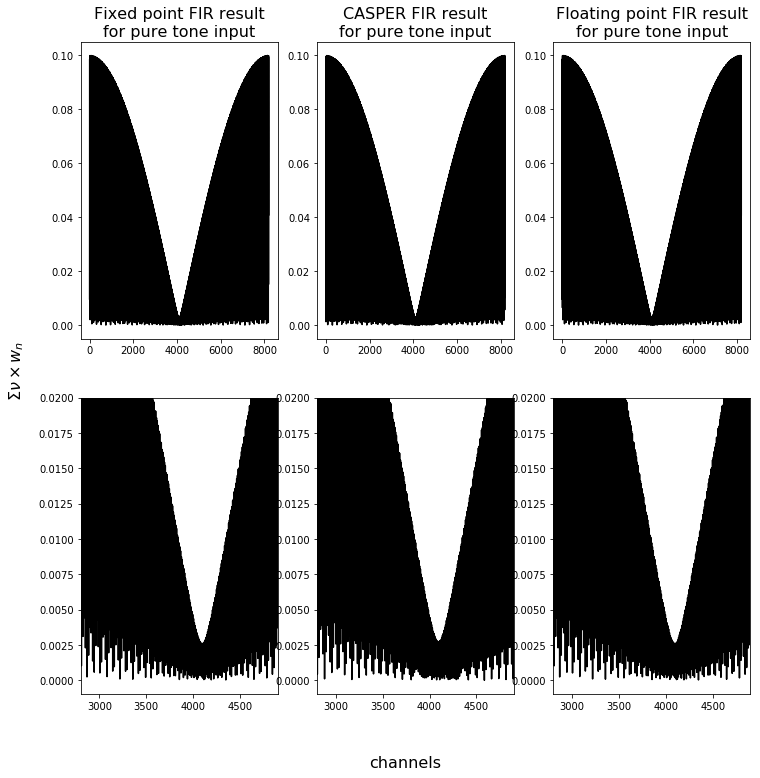

In [11]:
%matplotlib inline
firresplotter(fxdfirres,casfirres,fltfirres,'for pure tone input')

Next, the noisy tone results:

In [13]:
firinputdatans = spio.loadmat('firinputdata_ns.mat', squeeze_me=True)['inputdata']
firoutputdatans = spio.loadmat('firoutputdata_ns.mat', squeeze_me=True)['outputdata']

Now that the noisy tone vectors are loaded from MATLAB vectors into Python, again, the FIR outputs are compared:

In [14]:
#CREATE FIXED AND FLOATING PFB's AND RUN ON INPUT DATA
#HAVE TO REPLICATE CODE FOUND IN THE PFB SIMULATORS TO GET THE LAST FIR OUTPUT (WHEN ALL FIRS WERE FULL)
pfbfltns = FloatPFB(2**13,8)
pfbfltns.run(firinputdatans)
datfirfxdns = cfixpoint(17,17)
datfirfxdns.from_complex(firinputdatans)
pfbfxdns = FixPFB(2**13,8,17,17,17,17,8191,17,chan_acc=False,w='hann')
pfbfxdns.run(datfirfxdns)
firoutfltns =np.sum(pfbfltns.reg*pfbfltns.window,axis=1)/ (2**pfbfltns.firsc)
X_realns = pfbfxdns.reg_real*pfbfxdns.window
X_imagns = pfbfxdns.reg_imag*pfbfxdns.window
prodgrthns = X_realns.bits - pfbfxdns.bits_fft-1
Xns = cfixpoint(real = X_realns.sum(axis=1),imag = X_imagns.sum(axis =1))                                 
Xns >> prodgrthns + pfbfxdns.firsc
Xns.bits = pfbfxdns.bits_fft
Xns.fraction = pfbfxdns.bits_fft
Xns.normalise()

#OUR OUTPUTS
fxdfirresns = np.abs(Xns.to_complex())
casfirresns = np.abs(firoutputdatans)
fltfirresns = np.abs(firoutfltns)

and plotting:

Input SNR:  60.54186563570287 
Fixed FFT SNR:  32.779364221836715 
CASPER FFT SNR:  31.078159415486436 
Floating FFT SNR:  32.77928166432894


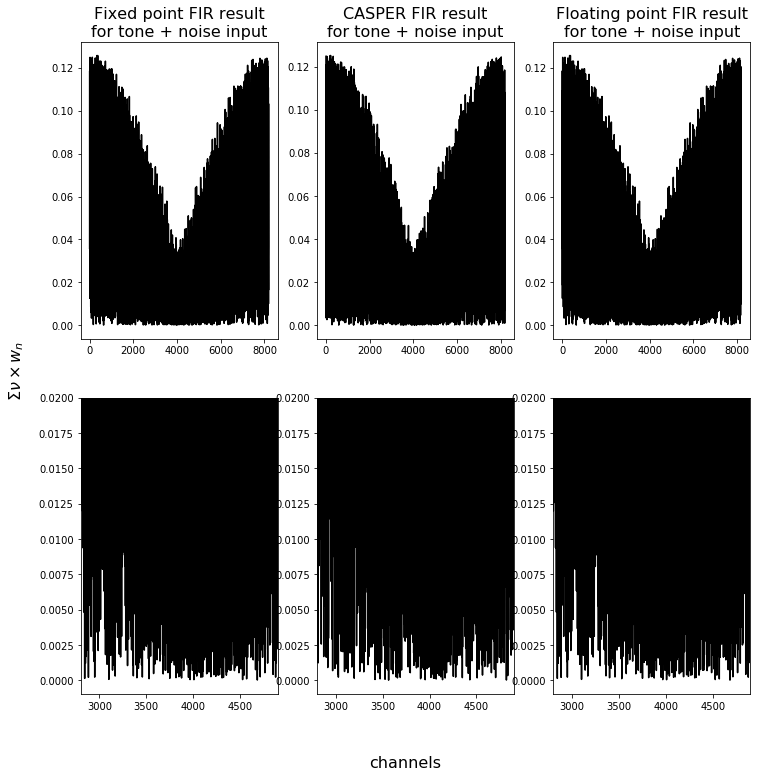

In [15]:
#PLOTTING
%matplotlib inline
firresplotter(fxdfirresns,casfirresns,fltfirresns,'for tone + noise input')

#CALCULATING SNR's
firinputsnr = 20*np.log10(np.max(firinputdata)/np.mean(firinputdatans-firinputdata))
fxdfirsnr = 20*np.log10(np.max(fxdfirres)/np.mean(fxdfirresns-fxdfirres))
casfirsnr = 20*np.log10(np.max(casfirres)/np.mean(casfirresns-casfirres))
fltfirsnr = 20*np.log10(np.max(fltfirres)/np.mean(fltfirresns-fltfirres))

print("Input SNR: ",firinputsnr, "\nFixed FFT SNR: ",fxdfirsnr,"\nCASPER FFT SNR: ",casfirsnr,"\nFloating FFT SNR: ",
     fltfirsnr)

The magnitudes in both FIR results are equal and there are similarities bit-wise. However, judging by the zoomed in view on the bottom row, either I've not taken the correct input vector to corresponding output vector or this may be owed to the simulator only requantising after both the multiplication and summation... while I think CASPER requantises after both individually.

The SNR measures here again show accuracy (though here there is a difference of 1.7dB between the CASPER and simulator result). 

### The PFB:
Finally, we look to compare the PFB results. Same as the FFT results, we'll use aggressive shifting (8191).

In [16]:
pfbinputdata = spio.loadmat('pfbinputdata.mat', squeeze_me=True)['inputdata']
pfboutputrealdata = spio.loadmat('pfbrealdataout.mat', squeeze_me=True)['realoutputdata']
pfboutputimagdata = spio.loadmat('pfbimagdataout.mat', squeeze_me=True)['imagoutputdata']

And, first loading the pure tone data from from MATLAB:

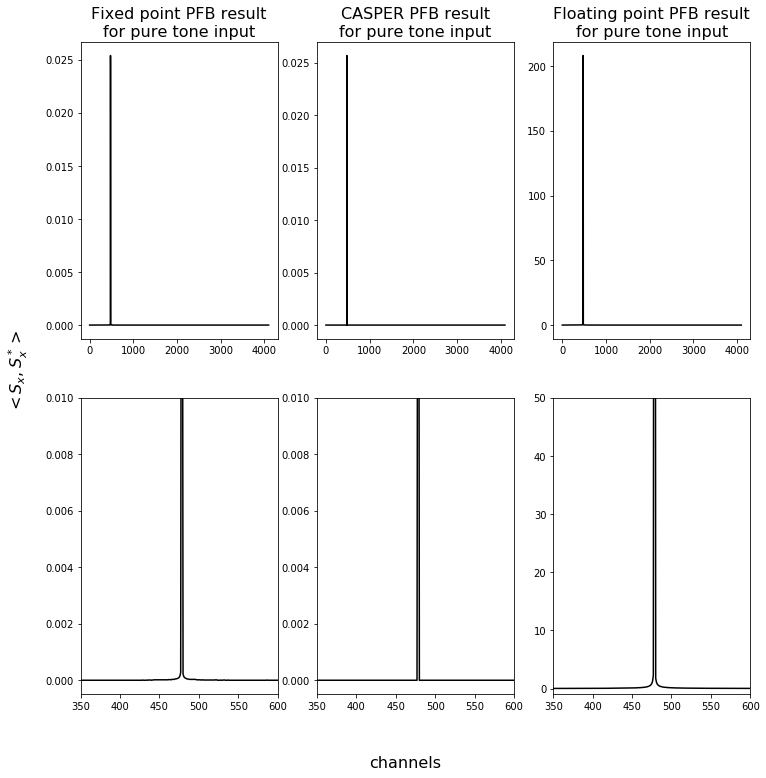

In [17]:
#BUILD AND RUN PFB INSTANCES
pfbflt = FloatPFB(2**13,8)
pfbflt.run(pfbinputdata)
datpfbfxd = cfixpoint(17,17)
datpfbfxd.from_complex(pfbinputdata)
pfbfxd = FixPFB(2**13,8,17,17,17,17,8191,17,chan_acc=False,w='hann')
pfbfxd.run(datpfbfxd)

#GET THE OUTPUTS
fxdpfbres = np.abs(pfbfxd.X_k.to_complex()[:,-1][:4096])
fltpfbres = np.abs(pfbflt.X_k)[:,-1][:4096]
caspfbres = np.abs(pfboutputrealdata+1j*pfboutputimagdata)

#PLOT
pfbresplotter(fxdpfbres,caspfbres,fltpfbres,'for pure tone input')

And now to test the noisy tone scenario:

In [18]:
pfbinputdatans = spio.loadmat('pfbinputdata_ns.mat', squeeze_me=True)['inputdata']
pfboutputrealdatans = spio.loadmat('pfbrealdataout_ns.mat', squeeze_me=True)['realoutputdata']
pfboutputimagdatans = spio.loadmat('pfbimagdataout_ns.mat', squeeze_me=True)['imagoutputdata']

Input SNR:  60.54186563570287 
Fixed PFB SNR:  43.590571038553456 
CASPER PFB SNR:  43.745264087833434 
Floating PFB SNR:  43.620123863220215
(array([479]),) (array([478]),) (array([478]),)


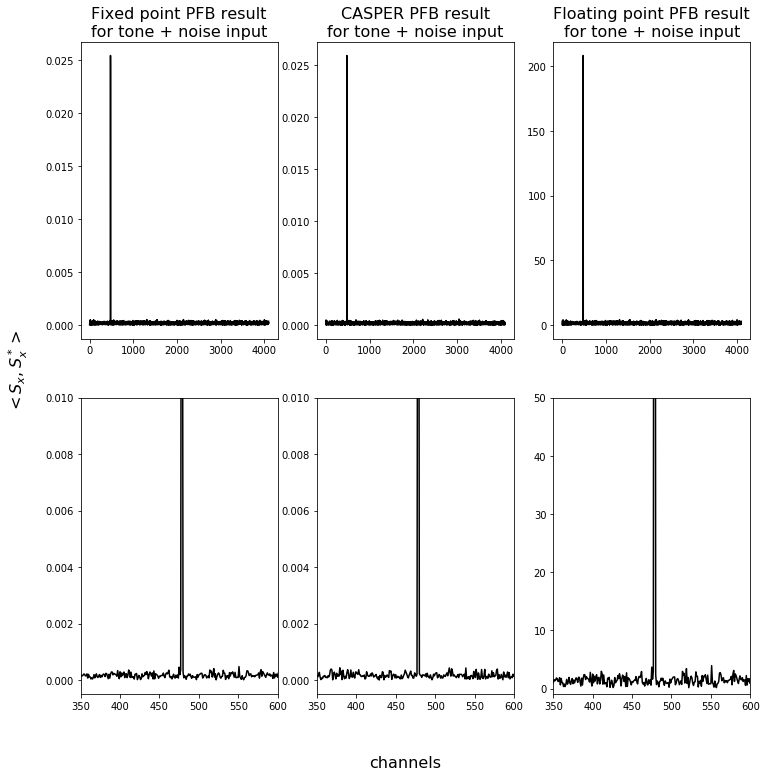

In [21]:
#BUILD AND RUN PFB INSTANCES
pfbfltns = FloatPFB(2**13,8)
pfbfltns.run(pfbinputdatans)
datpfbfxdns = cfixpoint(17,17)
datpfbfxdns.from_complex(pfbinputdatans)
pfbfxdns = FixPFB(2**13,8,17,17,17,17,8191,17,chan_acc=False,w='hann')
pfbfxdns.run(datpfbfxdns)

#GET THE OUTPUTS
fxdpfbresns = np.abs(pfbfxdns.X_k.to_complex()[:,-1][:4096])
fltpfbresns = np.abs(pfbfltns.X_k)[:,-1][:4096]
caspfbresns = np.abs(pfboutputrealdatans+1j*pfboutputimagdatans)

#PLOT
pfbresplotter(fxdpfbresns,caspfbresns,fltpfbresns,'for tone + noise input')

#CALCULATE SNR's
pfbinputsnr = 20*np.log10(np.max(pfbinputdata)/np.mean(pfbinputdatans-pfbinputdata))
fxdpfbsnr = 20*np.log10(np.max(fxdpfbres)/np.mean(fxdpfbresns-fxdpfbres))
caspfbsnr = 20*np.log10(np.max(caspfbres)/np.mean(caspfbresns-caspfbres))
fltpfbsnr = 20*np.log10(np.max(fltpfbres)/np.mean(fltpfbresns-fltpfbres))

print("Input SNR: ",pfbinputsnr, "\nFixed PFB SNR: ",fxdpfbsnr,"\nCASPER PFB SNR: ",caspfbsnr,"\nFloating PFB SNR: ",
     fltpfbsnr)

print(np.where(caspfbresns>=np.max(caspfbresns)),np.where(fxdpfbresns>=np.max(fxdpfbresns)),np.where(fltpfbresns>=np.max(fltpfbresns)))

Again, we have very similar magnitudes between the simulation and CASPER result, and the SNR values are very comparable. Again however, I'm not seeing any bit-wise similarities like with the FFT... making me wonder whether this is owed to the FIR or to the non-matching input and output vectors. 

Furthermore, the spike for the CASPER result is in channel 429 whilst the fixed and floating point results have it in channel 428. This could be (though I've checked) as a result of inaccurately getting the data from the CASPER PFB or as a result of the tone being non-commensurate. When processing it as a pure FFT it spreads over channels 428 and 429 (due to it being non-commensurate), but then the PFB allocates it to one or the other. Why they differ however may be owed to the behaviour explained below.

### Queer Behaviour:
While the FFT results appear the same, this is as a result of only inspecting the power. If we inspect the real and imaginary values for the FFT results you see the following:

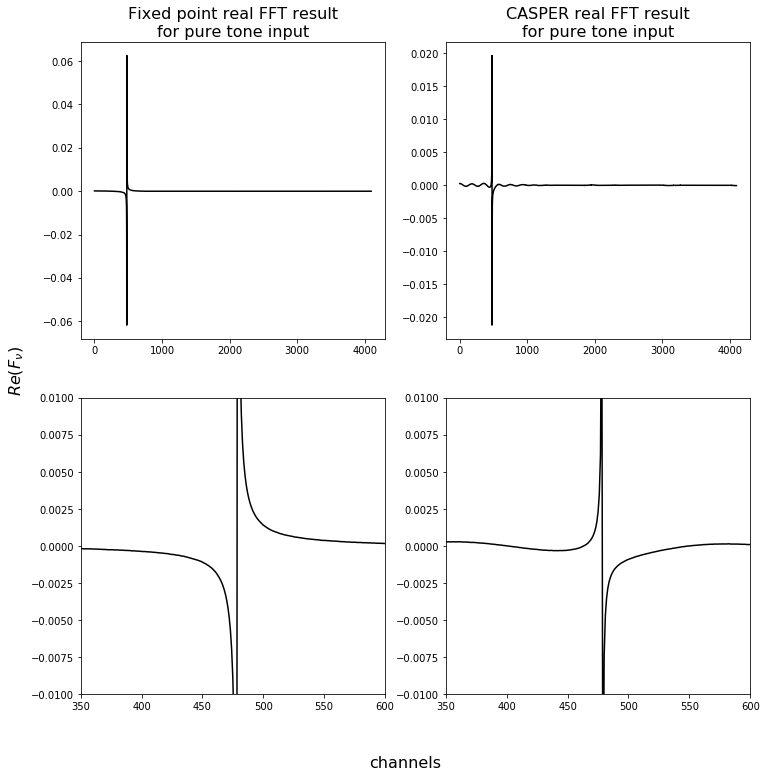

In [22]:
fftrresplotter(fxdfft.real.to_float()[:4096],fftrealoutputdata, 'for pure tone input')

As you can see, the CASPER FFT has a switched real result to the simulated FFT (and a regular software FFT for that matter). The same is true for the imaginary part. I'm not sure why CASPER has this 'flipped' FFT but I will investigate it.

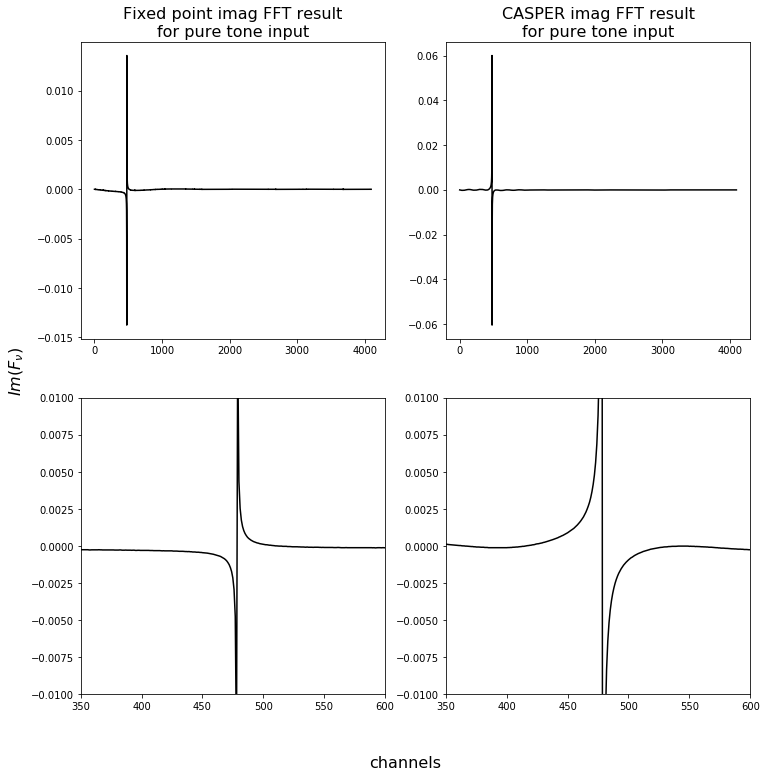

In [23]:
fftiresplotter(fxdfft.imag.to_float()[:4096],fftimagoutputdata, 'for pure tone input')

This behaviour is not noticed for commensurate tones and also is not noticed when absoluting the FFT results because then we get channels 428 and 429 populated by the spike.

This is not hugely important, but is something I aim to investigate next week. Perhaps there is some strange phase flip the CASPER FFT does that I am not aware of.

Further results I've been working on to follow.